<a href="https://colab.research.google.com/github/stevenzengg/MgNet/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MATH 497: Final Project

Remark: 

Please upload your solutions for this project to Canvas with a file named "Final_Project_yourname.ipynb".

=================================================================================================================

## Problem 1:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Setting $J=4$, $n=2^J-1$ and the number of iterations $M=100$, we perform the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* We plot the surface of solution $u_{GD}$ and $u_{MG}$.

* We define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. We then plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (the x-axis is $m$ and the y-axis is the error). We then combine both plots together in the same figure for more accurate comparison.

* We find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, psuedocode:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, psuedocode:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

=================================================================================================================

# Results of Problem 1:

###Multigrid Code:
*Includes both graphs and error calculations

The minumum iterations to achieve error < 1e-5 is  12
Time cost 0.04585862159729004


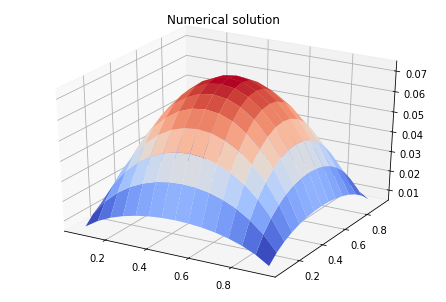

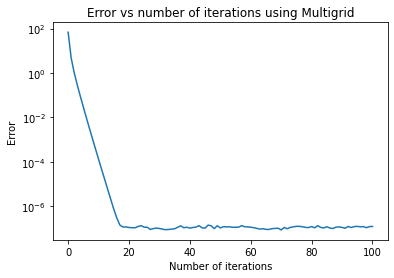

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####
        self.A = A
        self.S = S
    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()
        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####   
        out = (u,f)
        return out


class MG(nn.Module):
  def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u    
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
        layers = []

        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)

            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]

  def forward(self, u, f):
    out = (u,f)
    u_list.append(u)
    for l in range (len(num_iteration)):
      out = getattr(self,'layer'+str(l))(out)
      u,f = out
      u_list.append(u)
    u,f = out
    return u



def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

  A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
  S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32)
  Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
  R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
  RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

  if A is not None:
      A.weight = torch.nn.Parameter(A_kernel)
    
  if S is not None:
      S.weight = torch.nn.Parameter(S_kernel)
        
  if Pi is not None:
      Pi.weight = torch.nn.Parameter(Pi_kernel)
    
  if R is not None:
      R.weight = torch.nn.Parameter(R_kernel)
    
  if RT is not None:
      RT.weight = torch.nn.Parameter(RT_kernel)
    
  return



def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()


def MG1(u,f,J,num_iteration):
    u_list.clear()                                     # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    return u


num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [2,2,2,2]
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)

MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

N = 2**J -1
f = torch.ones(1,1,N,N)/(N+1)**2
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]
u_list =[]

t0 = time.time() 
for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error.append(np.linalg.norm((A(u)-f).detach().numpy()))
    if error[-1]<1e-5 and error[-2]>1e-5:
      print('The minumum iterations to achieve error < 1e-5 is ', m)
      print('Time cost', time.time() - t0)
plot_solution(J,u,"Numerical solution")
plot_error(M, error, "Multigrid")

###Gradient Descent Code:
*Includes both graphs and error calculations

The minumum iterations to achieve error < 1e-5 is  793
Time cost 0.17156481742858887


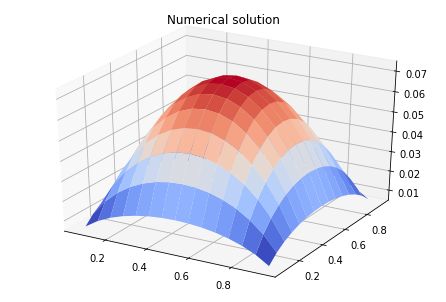

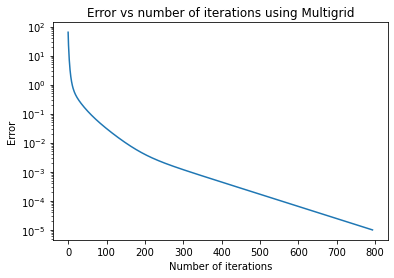

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time



class MgIte(nn.Module):
    def __init__(self, A):
        super().__init__()
        get_mg_init(A=A)                       ##### For MG: inilization of A, S #####
        self.A = A
    
    def forward(self, out):
        u, f = out
        u = u + (.125*(((f-self.A(u)))))                                   ##### For MG: u = u + S*(f-A*u) #####
        out = (u, f)
        return out


class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()
        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A_old*u_old) + A*u #####   
        out = (u,f)
        return out


class MG(nn.Module):
  def __init__(self, A):
        super().__init__()
        self.A = A  

  def forward(self, u, f):
    u,f = MgIte(self.A).forward((u, f))
    return u



def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

  A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
  Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
  R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
  RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

  if A is not None:
      A.weight = torch.nn.Parameter(A_kernel)
        
  if Pi is not None:
      Pi.weight = torch.nn.Parameter(Pi_kernel)
    
  if R is not None:
      R.weight = torch.nn.Parameter(R_kernel)
    
  if RT is not None:
      RT.weight = torch.nn.Parameter(RT_kernel)
    
  return



def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)   # create a mesh
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)         # plot a 3D surface, (X,Y,u(X,Y))
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    #print(np.linalg.norm((f-self.A(u)).reshape(-1).detach().numpy()))
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()


def MG1(u,f):                                   # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    return u


A = nn.Conv2d(1,1, kernel_size=3, stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)


MG0=MG(A)
J=4
N = 2**J -1
f = torch.ones(1,1,N,N)/(N+1)**2
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]
m=0
t0 = time.time() 
while error[-1]>1e-5:
    u = MG1(u,f)
    error.append(np.linalg.norm((A(u)-f).detach().numpy()))
    m+=1
print('The minumum iterations to achieve error < 1e-5 is ', m)
print('Time cost', time.time() - t0)
plot_solution(J,u,"Numerical solution")
plot_error(M, error, "Multigrid")

###Summary

| Method           | $\nu$ or $\eta$ | #iterations | computational time (s) |
|:-----------------|:-----------|:--------------------|:-------------------|
| Multigrid        | [2,2,2,2]  |    12 |0.04585862159729004                 |
| Gradient Descent |  .125      |         793           | 0.17156481742858887                   |

### Conclusions

#### *Multigrid proves a more effective model in solving the linear system above, taking only 12 iterations to reach an error < 10^-5 compared to 660 by the gradient descent method. Further testing on different linear systems will be required to generalize the statement. 
#### *Gradient Descent utilized only one for loop which was the basic formula iteration at the bottom of my code. However, as multigrid created sequentials for the different layer iterations, multigrid utilized lists as well as an extensive loop system for every iteration. These proved to be more effective in limiting the number of required iterations and computation time.
#### *The major difference between using [1,0,0,0] for v as compared to the pure gradient descent method lies in the utilization of S as a Conv2D function rather than the .125 eta.

## Problem 2:

We test SGD with momentum and weight decay by training MgNet on the Cifar10 dataset. We set the paramenters at 120 epochs, .1 initial learning rate, .9 momentum, 0.0005 weight decay, and decreasing learning rate (division by 10 every 30 epochs). Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ denote the best test accuracy attained during training.


### Tasks:
   * We train MgNet with the following three sets of hyper-parameters ($\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, where we implement $S^{l,i}$, preventing different iterations in the same layer from sharing the same $S^{l}$. 
  
  
   * For each numerical experiment above, the results are formatted as below:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * For each numerical experiment above, we plot the test accuracy against the epoch count.
   
   
   * Research Question: How many parameters does each model above have? Does the number of parameters positively affect precision rates?
       

# Results of Problem 2:

###MgNet Code:
*Includes all three models where model, model2, model2 correspond to (1), (2), (3)

*Includes graphs and parameter counts

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, training accuracy: 0.50904, test accuracy: 0.5326
Epoch: 1, learning rate: 0.1, training accuracy: 0.4603, test accuracy: 0.4636
Epoch: 1, learning rate: 0.1, training accuracy: 0.51874, test accuracy: 0.5174
Computation Time for one epoch: 127.6440375279999
Epoch: 2, learning rate: 0.1, training accuracy: 0.61762, test accuracy: 0.6085
Epoch: 2, learning rate: 0.1, training accuracy: 0.62304, test accuracy: 0.6216
Epoch: 2, learning rate: 0.1, training accuracy: 0.63704, test accuracy: 0.6293
Computation Time for one epoch: 127.88108770100007
Epoch: 3, learning rate: 0.1, training accuracy: 0.72318, test accuracy: 0.7165
Epoch: 3, learning rate: 0.1, training accuracy: 0.59028, test accuracy: 0.5793
Epoch: 3, learning rate: 0.1, training accuracy: 0.723, test accuracy: 0.723
Computation Time for one epoch: 126.7726966350001
Epoch: 4, learning rate: 0.1, training accu

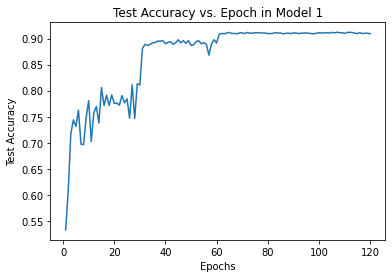

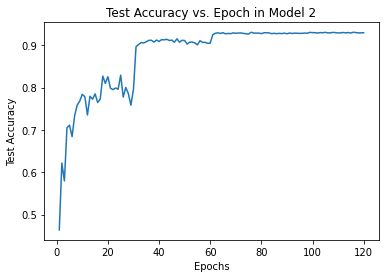

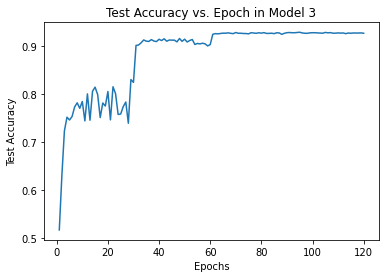

Model 1 has 520394 Parameters
Model 2 has 521418 Parameters
Model 3 has 668874 Parameters


In [ ]:
use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out                              
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out

class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))
            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A       
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        out = (u, f) 
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u 

class MG1(MG):
  def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))
            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A       
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)


def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


minibatch_size = 128
num_epochs = 120
lr = 0.1
num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [1,1,1,1]
num_iteration2 = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)
my_model2 = MG(num_channel_input, num_iteration2, num_channel_u, num_channel_f, num_classes)
my_model3 = MG1(num_channel_input, num_iteration2, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()
    my_model2 = my_model2.cuda()
    my_model3 = my_model3.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
optimizer2 = optim.SGD(my_model2.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
optimizer3 = optim.SGD(my_model3.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()
epochx = range(1,num_epochs+1)
tAccuracy = []
tAccuracy2 = []
tAccuracy3 = []
def plot(x,y, num):
  plt.figure()
  plt.title("Test Accuracy vs. Epoch in Model {}".format(num))
  plot = plt.plot(x, y)
  plt.xlabel("Epochs")
  plt.ylabel("Test Accuracy")
  plt.show()

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()
    current_lr = adjust_learning_rate(optimizer, epoch, lr)
    current_lr = adjust_learning_rate(optimizer2, epoch, lr)
    current_lr = adjust_learning_rate(optimizer3, epoch, lr)
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters


    my_model2.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model2(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer2.zero_grad()
        loss.backward()  #backpropragation
        optimizer2.step() #update the weights/parameters



    my_model3.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model3(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer3.zero_grad()
        loss.backward()  #backpropragation
        optimizer3.step() #update the weights/parameters





  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total



    my_model2.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model2(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy2 = float(correct)/total



    my_model3.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model3(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy3 = float(correct)/total



    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total


    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model2(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy2 = float(correct)/total


    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model3(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy3 = float(correct)/total

    tAccuracy.append(test_accuracy)
    tAccuracy2.append(test_accuracy2)
    tAccuracy3.append(test_accuracy3)

    
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy2,test_accuracy2)) 
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy3,test_accuracy3)) 

    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)
plot(epochx, tAccuracy, 1)
plot(epochx, tAccuracy2, 2)
plot(epochx, tAccuracy3, 3)
print("Model {} has {} Parameters".format(1, sum(param.numel() for param in my_model.parameters())))
print("Model {} has {} Parameters".format(2, sum(param.numel() for param in my_model2.parameters())))
print("Model {} has {} Parameters".format(3, sum(param.numel() for param in my_model3.parameters())))


### Summary 

|      Model            | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|
| MgNet with $S^{l}$ | 64, 64 |  [1,1,1,1] | .9119           |                  520394              |
| MgNet with $S^{l}$    |   64, 64   |  [2,2,2,2] |  .9307             |               521418                 |
| MgNet with $S^{l,i}$  |    64, 64    |  [2,2,2,2] |    .9281                 |             668874                   |

### Conclusions

#### *Although unexpected, the second model achieved the highest test precision. Theoretically, the third model with changing S Conv2D should eliminate multiple "bad" S-Kernels by drawing from a uniform distribution. However, that did not prove to increase precision given runtime deficiencies. 
#### *As expected, as iterations increased, the thoroughness of the model increased and thus the test accuracy score also correspondingly increased by 1-2%. 
#### * The parameters are determined by the combination of iteraction x Cu x Sli. The number of parameters does not necessarily increase accuracy, as iterations can prove redundant.

=================================================================================================================

## Problem 3:

We test the number of channels on MgNet Accuracy. (We use the same notation as in the previous problem.) We will double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * We report $b^{*}$, $\nu$ and the number of parameters of the model for each experiment we run.
   * We plot the test accuracy against the epoch count for the best experiment.

# Results of Problem 3

###MgNet Code:
*Includes 2 models and graphs, and parameter counts

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, training accuracy: 0.5052, test accuracy: 0.5008
Epoch: 1, learning rate: 0.1, training accuracy: 0.41512, test accuracy: 0.4222
Computation Time for one epoch: 156.44822061600007
Epoch: 2, learning rate: 0.1, training accuracy: 0.6201, test accuracy: 0.6228
Epoch: 2, learning rate: 0.1, training accuracy: 0.49554, test accuracy: 0.4942
Computation Time for one epoch: 156.440082136
Epoch: 3, learning rate: 0.1, training accuracy: 0.66326, test accuracy: 0.653
Epoch: 3, learning rate: 0.1, training accuracy: 0.57902, test accuracy: 0.5708
Computation Time for one epoch: 156.453690823
Epoch: 4, learning rate: 0.1, training accuracy: 0.77086, test accuracy: 0.77
Epoch: 4, learning rate: 0.1, training accuracy: 0.61004, test accuracy: 0.5882
Computation Time for one epoch: 156.49160471899995
Epoch: 5, learning rate: 0.1, training accuracy: 0.77056, test accuracy: 0.7596
E

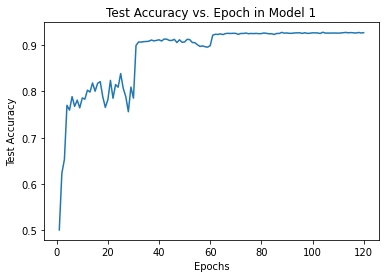

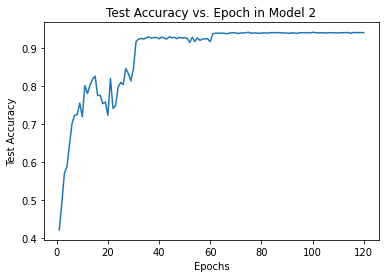

Model 1 uses [1,1,1,1] for v, or iterations. Model 2 uses [2,2,2,2].


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out                              
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out

class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))
            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A       
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        out = (u, f) 
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u 


def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


minibatch_size = 128
num_epochs = 120
lr = 0.1
num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10 
num_iteration = [1,1,1,1]
num_iteration2 = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)
my_model2 = MG(num_channel_input, num_iteration2, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()
    my_model2 = my_model2.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
optimizer2 = optim.SGD(my_model2.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)

# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()
epochx = range(1,num_epochs+1)
tAccuracy = []
tAccuracy2 = []
def plot(x,y, num):
  plt.figure()
  plt.title("Test Accuracy vs. Epoch in Model {}".format(num))
  plot = plt.plot(x, y)
  plt.xlabel("Epochs")
  plt.ylabel("Test Accuracy")
  plt.show()

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()
    current_lr = adjust_learning_rate(optimizer, epoch, lr)
    current_lr = adjust_learning_rate(optimizer2, epoch, lr)
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters


    my_model2.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model2(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer2.zero_grad()
        loss.backward()  #backpropragation
        optimizer2.step() #update the weights/parameters


  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total



    my_model2.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model2(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy2 = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total


    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model2(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy2 = float(correct)/total


    tAccuracy.append(test_accuracy)
    tAccuracy2.append(test_accuracy2)

    
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy2,test_accuracy2)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

max1 = max(tAccuracy)
max2 = max(tAccuracy2)
bigmax = max(max1, max2)
bigmin = min(max1, max2)
bigplot = [tAccuracy, tAccuracy2]
for i in range(len(bigplot)):
  if bigmax in bigplot[i]:
    print("Model {} has the highest max test accuracy among the two models: {}, and has {} Parameters.".format(i+1, bigmax, sum(param.numel() for param in my_model.parameters())))
  else:
    print("Model {}'s highest max test accuracy is {}, and has {} Parameters.".format(i+1, bigmin, sum(param.numel() for param in my_model2.parameters())))
plot(epochx, tAccuracy, 1)
plot(epochx, tAccuracy2, 2)


print("Model 1 uses [1,1,1,1] for v, or iterations. Model 2 uses [2,2,2,2].")

### Summary 

|                  | $c_u, c_f$ | $\nu$      | test accuracy $b^*$ | #parameters |
|:-----------------|:-----------|:-----------|:--------------------|:------------------|
|                  |    128, 128        |    [1,1,1,1]        |         .9278            |              2075018     | 
|                  |     128, 128       |  [2,2,2,2]           |            .9406         |          2072970         | 


### Conclusions

#### *We changed the number of channels of u and f to both be 128 for each model. As expected, and seen from the previous problem, utilizing more iterations will allow higher test accuracies.  
#### *Furthermore, the increase of channels u and f also increased the accuracy of the models as compared to the last problem's.

=================================================================================================================

## Problem 4:

We continue testing using larger MgNet models (i.e. increased number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  We experiment with different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Parameters of interest include number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, different $S^{l,i}$ in the same layer $l$, etc...

=================================================================================================================

# Results for Problem 4:


###MgNet Code:

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out                              
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out

class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()
        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out

class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))
            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A       
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        out = (u, f) 
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u

def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


minibatch_size = 256
num_epochs = 120
lr = 0.07
num_channel_input = 3
num_channel_u = 256
num_channel_f = 256
num_classes = 10 
num_iteration = [3,3,3,3]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)


if use_cuda:
    my_model = my_model.cuda()


# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()
epochx = range(1,num_epochs+1)
tAccuracy = []
def plot(x,y, num):
  plt.figure()
  plt.title("Test Accuracy vs. Epoch in Model {}".format(num))
  plot = plt.plot(x, y)
  plt.xlabel("Epochs")
  plt.ylabel("Test Accuracy")
  plt.show()

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()
    current_lr = adjust_learning_rate(optimizer, epoch, lr)
    # current_lr = adjust_learning_rate(optimizer2, epoch, lr)
    # current_lr = adjust_learning_rate(optimizer3, epoch, lr)
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters




  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total



    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total


    tAccuracy.append(test_accuracy)

    
    print('Epoch: {}, learning rate: {}, training accuracy: {}, test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)
    if test_accuracy>=.95:
      break
end = timer()



print("Model {} has {} Parameters".format(1, sum(param.numel() for param in my_model.parameters())))



Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.07, training accuracy: 0.5097, test accuracy: 0.5129
Computation Time for one epoch: 269.76014190400019
Epoch: 2, learning rate: 0.07, training accuracy: 0.64726, test accuracy: 0.6366
Computation Time for one epoch: 269.79476336099992
Epoch: 3, learning rate: 0.07, training accuracy: 0.71936, test accuracy: 0.7084
Computation Time for one epoch: 269.79984556599993
Epoch: 4, learning rate: 0.07, training accuracy: 0.78904, test accuracy: 0.7785
Computation Time for one epoch: 269.79397213900006
Epoch: 5, learning rate: 0.07, training accuracy: 0.76308, test accuracy: 0.7518
Computation Time for one epoch: 269.77379810999992
Epoch: 6, learning rate: 0.07, training accuracy: 0.81762, test accuracy: 0.804
Computation Time for one epoch: 269.78300297799979
Epoch: 7, learning rate: 0.07, training accuracy: 0.80888, test accuracy: 0.7927
Computation Time for one epoch: 269.782

### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$  | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:-----------|:-------------------------|
|    |     256, 256      |      [3,3,3,3]     |.9504                     |            13001482        |         lr, minibatch_size   |                          |



### Conclusions

#### *By increasing the number of iterations, channels of u, and channels of f, we are create a more robust model which increases precision. Furthermore, we lowered the learning rate by 30% every epoch which delayed the final bottleneck and allowed us to slowly but surely increase to 95% precision. The difference in learning rate and # of epochs is important when determining whether further iterations will prove useful.
#### *Note: By increasing the minibatch size, theoretically we have damaged the potential of the model as the parameters update less frequently. However, for practical purposes, doing so allowed the computational time to decrease drastically.